In [61]:
%load_ext autoreload
%autoreload 2
import os, sys
import glob
import json
import torch
import numpy as np
import pandas as pd
from natsort import natsorted
from tqdm import tqdm

sys.path.append('/dartfs/rc/lab/F/FinnLab/tommy/isc_asynchrony_behavior/code/utils/')
sys.path.append('/dartfs/rc/lab/F/FinnLab/tommy/isc_asynchrony_behavior/code/modeling/careful-whisper/')

from config import *

sys.path.append('/dartfs/rc/lab/F/FinnLab/tommy/isc_asynchrony_behavior/code/modeling/preproc-datasets/utils/')

import utils

# import careful_whisper_utils as whisper
# from src.models.components.careful_whisper import CarefulWhisper, CarefulWhisperConfig
# from src.data.components.audio_text_dataset import AudioTextDataset
# from src.data.audio_text_datamodule import AudioTextDataModule

# from torch.utils.data import DataLoader
# from src.data.components.collators import audio_text_collator


Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /dartfs/rc/lab/F/FinnLab/tommy/models/token
Login successful


In [ ]:
dataset_dir = os.path.join(DATASETS_DIR, 'nlp-datasets', 'voxceleb2', 'src/video/dev/')

speaker_ids = os.listdir(dataset_dir)

for sid in tqdm(speaker_ids):
    speaker_dir = os.path.join(dataset_dir, sid)
   
    # Check if the speaker directory exists
    if os.path.isdir(speaker_dir):
        vid_dirs = glob.glob(os.path.join(speaker_dir, sid, '*'))  # Assuming this is the pattern you need

        # Loop through each video directory (vid_dir)
        for vid_dir in vid_dirs:
            # Check if vid_dir exists and it's a directory
            if os.path.isdir(vid_dir):
                # Construct the destination directory (the corresponding subdirectory in speaker_dir)
                speaker_vid_dir = os.path.join(speaker_dir, os.path.basename(vid_dir))
                
                # Move the files inside vid_dir to speaker_vid_dir if speaker_vid_dir exists
                if os.path.exists(speaker_vid_dir) and os.path.isdir(speaker_vid_dir):
                    # print(f"Moving files from {vid_dir} to {speaker_vid_dir}")
                    
                    # Loop through files in vid_dir and move them to speaker_vid_dir
                    for file_name in os.listdir(vid_dir):
                        file_path = os.path.join(vid_dir, file_name)
                        if os.path.isfile(file_path):  # Ensure it's a file, not a subdirectory
                            dest_file_path = os.path.join(speaker_vid_dir, file_name)
                            
                            # Move the file
                            shutil.move(file_path, dest_file_path)
                    
                    # Optionally, remove the now-empty vid_dir after moving the files
                    if not os.listdir(vid_dir):  # If it's empty
                        os.rmdir(vid_dir)
                # else:
                #     print(f"Skipping {vid_dir} as {speaker_vid_dir} does not exist or is not a directory.")

  0%|          | 0/5994 [00:00<?, ?it/s]

 26%|██▌       | 1566/5994 [00:24<01:53, 39.11it/s]  

In [99]:
glob.glob(f"{vid_dir}/*")

['/dartfs/rc/lab/F/FinnLab/datasets/nlp-datasets/voxceleb2/src/video/dev/id08525/id08525/H4GMba-4YKY/00311.mp4',
 '/dartfs/rc/lab/F/FinnLab/datasets/nlp-datasets/voxceleb2/src/video/dev/id08525/id08525/H4GMba-4YKY/00314.mp4']

In [ ]:
import shutil


False

In [89]:
shutil.move(vid_dirs[0], speaker_dir)

'/dartfs/rc/lab/F/FinnLab/datasets/nlp-datasets/voxceleb2/src/video/dev/id08525/x36RP-GPEKg'

In [79]:
glob.glob(os.path.join(speaker_dir, '*'))

['/dartfs/rc/lab/F/FinnLab/datasets/nlp-datasets/voxceleb2/src/video/dev/id06393/3aKR_VO9bLM',
 '/dartfs/rc/lab/F/FinnLab/datasets/nlp-datasets/voxceleb2/src/video/dev/id06393/OzZiYmIl-aU',
 '/dartfs/rc/lab/F/FinnLab/datasets/nlp-datasets/voxceleb2/src/video/dev/id06393/hpAmpysWBIo',
 '/dartfs/rc/lab/F/FinnLab/datasets/nlp-datasets/voxceleb2/src/video/dev/id06393/EYPo33H-QeM',
 '/dartfs/rc/lab/F/FinnLab/datasets/nlp-datasets/voxceleb2/src/video/dev/id06393/4R76n2TTR4E',
 '/dartfs/rc/lab/F/FinnLab/datasets/nlp-datasets/voxceleb2/src/video/dev/id06393/Xht059Fq96Y',
 '/dartfs/rc/lab/F/FinnLab/datasets/nlp-datasets/voxceleb2/src/video/dev/id06393/Q7gsnTtzJv0']

### Test ternary plot

In [62]:
results_dir = os.path.join(BASE_DIR, 'derivatives/results/behavioral/')
window_size = 25
df_distributions = pd.read_csv(os.path.join(results_dir, f'all-task_group-analyzed-behavior_window-size-{str(window_size).zfill(5)}_human-model-distributions-lemmatized.csv'))

df_kl_difference = []

modality_pairs = [('video', 'text'), ('audio', 'text'), ('video', 'audio')]
modality_columns = ['-'.join(pair) for pair in modality_pairs]

for (task, model_name), df in df_distributions.groupby(['task', 'model_name']):

    all_contrasts = []

    for mod1, mod2 in modality_pairs:
        df_mod1 = df[df['modality'] == mod1].reset_index(drop=True)
        df_mod2 = df[df['modality'] == mod2].reset_index(drop=True)

        kl_diff = (df_mod2['kl_divergence'] - df_mod1['kl_divergence']).to_numpy()
        all_contrasts.append(kl_diff)
    
    all_contrasts = np.stack(all_contrasts)
    df_diff = pd.DataFrame(all_contrasts.T, columns=modality_columns)
    df_diff['task'] = task
    df_diff['model_name'] = model_name
    df_kl_difference.append(df_diff)
    
df_kl_difference = pd.concat(df_kl_difference).reset_index(drop=True)

In [63]:
# Function to normalize negative values for ternary plotting
def normalize_for_ternary(points):
    # Shift all points to make them non-negative
    shifted = points - np.min(points, axis=1).reshape(-1, 1)
    # Normalize to sum to 1
    row_sums = shifted.sum(axis=1).reshape(-1, 1)
    normalized = shifted / row_sums
    return normalized

# Function to shift data without changing the scale
def shift_for_ternary(point):
    # Find the minimum value across all points
    min_value = np.min(points)
    
    # Shift all values to make them non-negative
    shifted = points - min_value
    
    # Return both the shifted points and the shift amount for reference
    return shifted, min_value

# Function to prepare data with even scaling
def prepare_for_ternary_even_scale(points, global_min, range_size):
    # Shift all values by the global minimum
    shifted = points - global_min
    
    # We want the same scale on each axis
    # For a ternary plot with even scaling, we use the same range for all dimensions
    scale_factor = 1.0  # Can be adjusted if needed
    
    return shifted, range_size * scale_factor




In [64]:
points = df_kl_difference.groupby('model_name')[modality_columns] \
    .median() \
    .to_numpy()
    
points, min_val = shift_for_ternary(points)

In [66]:
df_kl_difference

,video-text,audio-text,video-audio,task,model_name
0,-0.024830,0.223966,-0.248796,black,bloom
1,-1.812893,-0.019729,-1.793165,black,bloom
2,-0.030316,-0.790371,0.760055,black,bloom
3,-0.322495,-0.248509,-0.073986,black,bloom
4,-1.052606,-0.465339,-0.587267,black,bloom
...,...,...,...,...,...
6043,-0.109592,0.136673,-0.246265,wheretheressmoke,xlm-prophetnet
6044,0.078822,0.061782,0.017040,wheretheressmoke,xlm-prophetnet
6045,-1.307054,-0.463889,-0.843164,wheretheressmoke,xlm-prophetnet
6046,0.823740,0.643922,0.179818,wheretheressmoke,xlm-prophetnet


/dartfs/rc/lab/F/FinnLab/tommy/conda/envs/dark_matter/lib/python3.9/site-packages/ternary/plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)


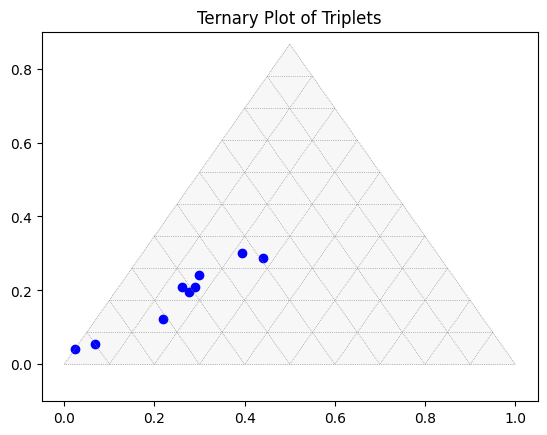

In [65]:
import ternary

# Create figure and ternary axes
fig, tax = ternary.figure(scale=1.0)
tax.set_title("Ternary Plot of Triplets")

# Plot the normalized points
tax.scatter(points, marker='o', color='blue', label="Random Points")

# Add gridlines
tax.gridlines(color="gray", multiple=0.1)

# # Set labels at vertices
# tax.left_axis_label(modality_columns[0])
# tax.right_axis_label(modality_columns[1])
# tax.bottom_axis_label(modality_columns[2])
    
# scale = 5
# figure, tax = ternary.figure(scale=scale)

# tax.boundary(linewidth=2.0)
# tax.gridlines(multiple=0.25, color="blue")

# # colors = ['r', 'g', 'b']
# tax.scatter(points, marker='s', color='red', label="Red Squares")


In [17]:
fns = glob.glob(os.path.join(DATASETS_DIR, 'nlp-datasets/voxceleb2/features/metadata/gpt2-wav2vec2-data2vec/test/temp/*'))

In [21]:
fn = '/dartfs/rc/lab/F/FinnLab/datasets/nlp-datasets/voxceleb2/features/metadata/gpt2-wav2vec2-data2vec/test/errors/id01541_WViRdsBRKtM_00164_processed.json'




In [28]:
glob.glob('/dartfs/rc/lab/F/FinnLab/datasets/nlp-datasets/voxceleb2/features/data2vec/test/id01541_WViRdsBRKtM_00164*')

['/dartfs/rc/lab/F/FinnLab/datasets/nlp-datasets/voxceleb2/features/data2vec/test/id01541_WViRdsBRKtM_00164_video-features.pt']

In [22]:
with open(fn, 'r') as f:
    data = json.load(f)

In [24]:
data

{'base_name': 'id01541_WViRdsBRKtM_00164',
 'text': 'i was peoplepleasing for too long and when youre peoplepleasing your soul is dead because at the end of the day youre left with yourself and you think god i didnt take care of myself',
 'text_tokens_path': '/dartfs/rc/lab/F/FinnLab/datasets/nlp-datasets/voxceleb2/features/gpt2/test/id01541_WViRdsBRKtM_00164_text-tokens.pt',
 'attention_mask_path': '/dartfs/rc/lab/F/FinnLab/datasets/nlp-datasets/voxceleb2/features/gpt2/test/id01541_WViRdsBRKtM_00164_attention-mask.pt',
 'prominence_path': '/dartfs/rc/lab/F/FinnLab/datasets/nlp-datasets/voxceleb2/features/prosody/test/id01541_WViRdsBRKtM_00164_prominence.pt',
 'boundary_path': '/dartfs/rc/lab/F/FinnLab/datasets/nlp-datasets/voxceleb2/features/prosody/test/id01541_WViRdsBRKtM_00164_boundary.pt'}

In [23]:
torch.load(data['audio_features_path'])

KeyError: 'audio_features_path'

In [ ]:
import os
import sys
import json
import glob
import torch
from transformers import AutoImageProcessor, AutoModel
from transformers import VideoMAEFeatureExtractor, AutoProcessor, AutoModelForVideoClassification
from torchvision.io import read_video

sys.path.append('/dartfs/rc/lab/F/FinnLab/tommy/isc_asynchrony_behavior/code/modeling/preproc-datasets/utils/')

import utils

In [61]:
import torch
import torch.nn.functional as F
import numpy as np

def pad_frames(video_frames, target_frames=16):
    """
    Pad video frames to a target number of frames for VideoMAE input.
    
    Args:
        video_frames (np.ndarray or torch.Tensor): Input video frames 
            with shape (num_frames, height, width, channels)
        target_frames (int, optional): Number of frames to pad to. 
            Defaults to 16 for VideoMAE.
    
    Returns:
        np.ndarray or torch.Tensor: Padded video frames
    """
    # Convert to numpy if input is a torch tensor
    if torch.is_tensor(video_frames):
        video_frames = video_frames.numpy()
    
    current_frames = video_frames.shape[0]
    
    # If we have more frames than target, truncate
    if current_frames > target_frames:
        return video_frames[:target_frames]
    
    # If we have fewer frames, pad
    if current_frames < target_frames:
        # Determine padding method (repeat the last frame)
        padding_frames = np.repeat(
            video_frames[-1:], 
            target_frames - current_frames, 
            axis=0
        )
        
        # Concatenate original frames with padding frames
        padded_frames = np.concatenate(
            [video_frames, padding_frames], 
            axis=0
        )
        
        return padded_frames
    
    # If exactly the right number of frames, return as-is
    return video_frames

### VideoMAE

In [125]:
fns = glob.glob(os.path.join('/dartfs/rc/lab/F/FinnLab/datasets/nlp-datasets/lrs3/video/test/*'))

image_processor = AutoImageProcessor.from_pretrained("MCG-NJU/videomae-base")
model = AutoModel.from_pretrained("MCG-NJU/videomae-base")

In [129]:
video_data = read_video(fns[0])[0]

full_data = image_processor(list(video_data[-16:, ...]), padding=True, return_tensors="pt")

full_data_outputs = model(**full_data)
full_data_embedding = full_data_outputs.last_hidden_state.mean(1)

video_data = read_video(fns[-1])[0]


inputs = list(pad_frames(video_data[:16, ...]))
padded_data = image_processor(inputs, padding=True, return_tensors="pt")

padded_data_outputs = model(**padded_data)
padded_data_embedding = padded_data_outputs.last_hidden_state.mean(1)
# last_hidden_states = outputs.last_hidden_state

/dartfs/rc/lab/F/FinnLab/tommy/conda/envs/prosody/lib/python3.12/site-packages/torchvision/io/video.py:169: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.")
/dartfs/rc/lab/F/FinnLab/tommy/conda/envs/prosody/lib/python3.12/site-packages/transformers/image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `VideoMAEImageProcessor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)


In [130]:
torch.cosine_similarity(full_data_embedding, padded_data_embedding)

tensor([0.9863], grad_fn=<SumBackward1>)

### Data2Vec

In [138]:
model_name = "facebook/data2vec-vision-large"
#"microsoft/resnet-18"
image_processor = AutoImageProcessor.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

In [139]:
video_data = read_video(fns[0])[0]

frame_a_inputs = image_processor(video_data[0,...], return_tensors="pt")

with torch.no_grad():
    frame_a_outputs = model(**frame_a_inputs)
    frame_a_embedding = utils.pool_embeddings(frame_a_outputs.last_hidden_state)
    # frame_a_embedding = F.normalize(frame_a_embedding, dim=1)

video_data = read_video(fns[0])[0]
frame_b_inputs = image_processor(video_data[-1,...], return_tensors="pt")

with torch.no_grad():
    frame_b_outputs = model(**frame_b_inputs)
    frame_b_embedding = utils.pool_embeddings(frame_b_outputs.last_hidden_state)

torch.cosine_similarity(frame_a_embedding, frame_b_embedding)

tensor([0.8992])

### DinoV2

In [135]:
model_name = "facebook/dinov2-base"
#"microsoft/resnet-18"
image_processor = AutoImageProcessor.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

preprocessor_config.json:   0%|          | 0.00/436 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [137]:
video_data = read_video(fns[0])[0]

frame_a_inputs = image_processor(video_data[0,...], return_tensors="pt")

with torch.no_grad():
    frame_a_outputs = model(**frame_a_inputs)
    frame_a_embedding = utils.pool_embeddings(frame_a_outputs.last_hidden_state)
    # frame_a_embedding = F.normalize(frame_a_embedding, dim=1)

video_data = read_video(fns[0])[0]
frame_b_inputs = image_processor(video_data[-1,...], return_tensors="pt")

with torch.no_grad():
    frame_b_outputs = model(**frame_b_inputs)
    frame_b_embedding = utils.pool_embeddings(frame_b_outputs.last_hidden_state)

torch.cosine_similarity(frame_a_embedding, frame_b_embedding)

tensor([0.9022])

### Res2Plus1D

In [198]:
from torch import nn
import torchvision.models.video as models

model = models.r3d_18(pretrained=True)

model = nn.Sequential(*list(model.children())[:-1])
model.eval()

/dartfs/rc/lab/F/FinnLab/tommy/conda/envs/prosody/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/dartfs/rc/lab/F/FinnLab/tommy/conda/envs/prosody/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/r3d_18-b3b3357e.pth" to /dartfs/rc/lab/F/FinnLab/tommy/models/hub/checkpoints/r3d_18-b3b3357e.pth
100%|██████████| 127M/127M [00:02<00:00, 48.7MB/s] 


Sequential(
  (0): BasicStem(
    (0): Conv3d(3, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (1): Sequential(
    (0): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (conv2): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNor

In [199]:
def extract_video_embedding(batch, model):
    # Prepare input tensor
    # Reshape to [batch_size, channels, frames, height, width]
    if len(batch.shape) == 4:
        batch = batch.unsqueeze(0)

    # Ensure correct input dimensions
    if batch.shape[1] != 3:  # If channels not first
        batch = batch.permute(0, 4, 1, 2, 3)

    # Normalize input (optional but recommended)
    mean = torch.tensor([0.43216, 0.394666, 0.37645]).view(1, 3, 1, 1, 1)
    std = torch.tensor([0.22803, 0.22145, 0.216989]).view(1, 3, 1, 1, 1)
    batch = (batch - mean) / std

    # Extract embedding
    with torch.no_grad():
        outputs = model(batch)
    return outputs

In [202]:
video_data_a = read_video(fns[0])[0]
video_data_b = torch.rand(1, 3, 10, 224, 224)#read_video(fns[100])[0]

In [203]:
embedding_a = extract_video_embedding(video_data_a, model).squeeze().unsqueeze(0)
embedding_b = extract_video_embedding(video_data_b, model).squeeze().unsqueeze(0)

torch.cosine_similarity(embedding_a, embedding_b)

tensor([0.1417])

### ResNet

In [120]:
model_name = "microsoft/resnet-18"

image_processor = AutoImageProcessor.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

In [123]:
video_data = read_video(fns[0])[0]

frame_a_inputs = image_processor(video_data[0,...], return_tensors="pt")

with torch.no_grad():
    frame_a_outputs = model(**frame_a_inputs)
    frame_a_embedding = F.adaptive_avg_pool2d(frame_a_outputs.last_hidden_state, output_size=1)
    # frame_a_embedding = F.normalize(frame_a_embedding, dim=1)

video_data = read_video(fns[-1])[0]
frame_b_inputs = image_processor(video_data[-1,...], return_tensors="pt")

with torch.no_grad():
    frame_b_outputs = model(**frame_b_inputs)
    frame_b_embedding = F.adaptive_avg_pool2d(frame_b_outputs.last_hidden_state, output_size=1)
    # frame_b_embedding = F.normalize(frame_b_embedding, dim=1)

### Test hydra models

In [209]:
%load_ext autoreload
%autoreload 2

import torch

import hydra
from hydra import initialize, compose
from lightning import LightningDataModule, LightningModule

import pyrootutils

from src import utils
from src.data.components.audio_text_dataset import AudioTextDataset
from src.data.components.collators import audio_text_collator

def load_model(config_path, overrides, ckpt_path=None):
    
    with initialize(version_base="1.3", config_path=config_path):
      cfg = compose(config_name="train.yaml", overrides=overrides)

    model: LightningModule = hydra.utils.instantiate(cfg.model)

    # Load the model from a checkpoint
    if ckpt_path:
      checkpoint = torch.load(ckpt_path, map_location=torch.device('cpu'))
      model.load_state_dict(checkpoint['state_dict'])
      model.eval()

    return cfg, model

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [210]:
dataset = 'lrs3'
# model_name = 'careful-whisper_causal-xattn-subset-0.30'
MODELS_DIR = os.path.join(BASE_DIR, 'code/modeling/careful-whisper/')
# CKPTS_DIR = os.path.join(MODELS_DIR, f'logs/train/careful-whisper/{dataset}/')

EXPERIMENT = ["experiment=careful_whisper.yaml"]

# Whisper w/ CLM integration
overrides =  [
    # f"model.config.input_dim1=1024",
    # f"model.config.input_dim2=1024",

    # f"model.config.input_name1=audio_features",
    # f"model.config.input_name2=video_features",
    # f"model.config.hidden_dim=1024"
    f"model.config.cross_attention=True",
    f"model.config.use_causal_cross_attention=True",

    # Prosody embedding information
    f"model.config.context_type=audiovisual_features",
    f"model.config.context_embed_dropout=0.1",
    f"model.config.context_pos_embed=True",

    # f"model.config.num_layers=6",
    # f"model.config.cross_attention=True",
    # f"model.config.use_causal_cross_attention=True",

    # # Add in dropout and position embedding
    # f"model.config.context_embed_dropout=0.1",
    # f"model.config.context_pos_embed=True",

    # for prosody
    # f"model.config.context_type=prominence",
    # f"model.config.context_dim=1",
]

overrides = EXPERIMENT + overrides

pyrootutils.setup_root(MODELS_DIR, indicator=".project-root", pythonpath=True)

# # Get relative path --> path for initialize needs to be relative
config_path = os.path.join(os.path.relpath(MODELS_DIR, os.getcwd()), 'configs')
cfg, model = load_model(config_path, overrides)

In [228]:

# DATASET = 'pfka-moth-stories'
# split = 'train'
DATASET = 'lrs3'
split = 'test'
text_model_name = 'gpt2'
audio_model_name = 'wav2vec2'
video_model_name = 'data2vec'

dataset_dir = os.path.join(DATASETS_DIR, 'nlp-datasets', 'lrs3')
# cache_dir = os.path.join(SCRATCH_DIR, 'nlp-datasets', DATASET)

# dataset_dir = os.path.join(dataset_dir, 'features', 'metadata', 'gpt2-wav2vec2-data2vec')
ckpt_path = '/dartfs/rc/lab/F/FinnLab/tommy/isc_asynchrony_behavior/code/modeling/careful-whisper/logs/train/token-fusion/lrs3/token-fusion_wav2vec-data2vec/checkpoints/epoch_013.ckpt'

datamodule = AudioTextDataModule(
    dataset_name='lrs3',
    data_dir=dataset_dir,
    text_model_name=text_model_name,
    audio_model_name=audio_model_name,
    video_model_name=video_model_name,
    token_fusion_method='mlp',
    batch_size=2,
    ckpt_path=ckpt_path,
)

datamodule.setup(stage='fit')

# included_fns = [item['base_name'] for item in preproc_dataset.metadata]


Loading data from /dartfs/rc/lab/F/FinnLab/datasets/nlp-datasets/lrs3/features/metadata/gpt2-wav2vec2-data2vec
Validation samples: 30461


In [229]:
for x in datamodule.train_dataloader():
    break

In [230]:
model(x)

tensor([[[-0.8792,  0.0667, -0.6307,  ..., -0.0477,  0.0668,  0.0000],
         [-0.7403, -0.3135, -0.4300,  ..., -0.1875,  0.0093,  0.0000],
         [ 0.1944, -0.5186, -0.0124,  ...,  0.3130, -0.2755,  0.0000],
         ...,
         [-0.5416,  0.9045,  0.3029,  ..., -0.3690,  0.3955,  0.0000],
         [-0.3318, -0.8728, -0.6927,  ..., -0.6815,  0.2117,  0.0000],
         [-0.1510,  0.6325,  0.1151,  ...,  0.0818,  1.1009,  0.0000]],

        [[-0.5912, -0.0736,  0.3283,  ..., -0.0781,  1.3526,  0.0000],
         [-0.0914, -0.1726, -0.2737,  ..., -0.1103,  0.7893,  0.0000],
         [-0.9703, -0.2927, -0.4138,  ..., -0.2866,  0.3642,  0.0000],
         ...,
         [-0.1011,  0.6565, -0.9231,  ..., -0.3555,  0.2675,  0.0000],
         [-0.5690, -1.0277, -0.6088,  ...,  0.4175,  0.3660,  0.0000],
         [-0.3588, -0.3456, -0.0543,  ...,  0.0127,  0.0871,  0.0000]]],
       grad_fn=<UnsafeViewBackward0>)

In [215]:
batch = preproc_dataset.__getitem__(0)

### Get amount of time within each dataset

#### First load our dataloader and grab file IDs

In [ ]:
from datasets import load_dataset

DATASET_CONFIGS = {
    'gigaspeech': {
        'name': 'speechcolab/gigaspeech',
        'config': 'm',
        'splits': ['train', 'validation', 'test'],
        'audio_key': 'audio',
        'text_key': 'text',
        'segment_key': 'segment_id',
        'target_sr': 16000  # Use original sampling rate
    },
    'peoples-speech': {
        'name': 'MLCommons/peoples_speech',
        'config': 'clean_sa',
        'splits': ['train'], #'validation', 'test'], # 
        'audio_key': 'audio',
        'text_key': 'text',
        'segment_key': 'id',
        'target_sr': 16000  # People's Speech needs consistent sampling rate
    },
    'libritts-r': {
        'name': 'mythicinfinity/libritts_r',
        'config': 'clean',
        'splits': ['train.clean.360', 'dev.clean', 'test.clean'],
        'audio_key': 'audio',
        'text_key': 'text_normalized',
        'segment_key': 'id',
        'target_sr': 16000  # Use original sampling rate
    },
    'tedlium': {
        'name': 'LIUM/tedlium',
        'config': 'release3',
        'splits': ['train', 'validation', 'test'],
        'audio_key': 'audio',
        'text_key': 'text',
        'segment_key': 'id',
        'target_sr': 16000  # Use original sampling rate
    }
}

### Functions for dataset statistics

In [ ]:
def count_unique_words(df, column_name):
    """
    Counts the number of unique words in a specified column of a Pandas DataFrame.

    Args:
        df (pd.DataFrame): The input DataFrame.
        column_name (str): The name of the column to analyze.

    Returns:
        int: The number of unique words in the column.
    """
    all_words = ' '.join(df[column_name].astype(str)).lower().split()
    total_words = len(all_words)
    unique_words = set(all_words)
    return total_words, len(unique_words)

def convert_ms_to_hms(milliseconds):
    seconds = (milliseconds // 1000) % 60
    minutes = (milliseconds // (1000 * 60)) % 60
    hours = (milliseconds // (1000 * 60 * 60))
    return f"{int(hours)}:{int(minutes)}:{seconds:02}"

def get_dataset_stats(dataset_name, dataset, config, included_fns):

    # Convert to pandas, filter, convert back
    df = dataset.to_pandas()
    df[config['segment_key']] = df[config['segment_key']].apply(os.path.basename)
    filtered_df = df[df[config['segment_key']].isin(included_fns)]

    indices = filtered_df.index.tolist()

    if dataset_name == 'gigaspeech':
        total_ms = np.sum(filtered_df['end_time'] - filtered_df['begin_time']) * 1000
    elif dataset_name == 'peoples-speech':
        total_ms = np.sum(filtered_df['duration_ms'])
    else:

        filtered_dataset = dataset.select(indices)

        total_ms = []
        for audio in tqdm(dataset['audio']):
            duration = len(audio['array']) / audio['sampling_rate']
            total_ms.append(duration)

        total_ms = np.sum(total_ms) * 1000

    total_time = convert_ms_to_hms(total_ms)

    total_words, unique_words = count_unique_words(filtered_df, config['text_key'])

    stats = {
        'total_words': total_words,
        'unique_words': unique_words,
        'total_time': total_time,
    }

    return stats

In [ ]:
odeldataset[0]

{'audio': {'path': None,
  'array': array([ 0.00018311,  0.00015259,  0.00149536, ..., -0.0005188 ,
          0.00134277,  0.00164795]),
  'sampling_rate': 16000},
 'text': '<unk> this is such a strange thing your software linux',
 'speaker_id': 'LinusTorvalds_2016',
 'gender': -1,
 'file': '/dartfs/rc/lab/F/FinnLab/tommy/models/datasets/downloads/extracted/3dfdd992fdf0b7ba99a35170c78dd2c0ee45b6464a1ee117d5846601257dca05/train/LinusTorvalds_2016.sph',
 'id': 'LinusTorvalds_2016-13.42-16.56-<NA>'}

In [ ]:
# Load from huggingface
DATASET = 'tedlium'
config = DATASET_CONFIGS[DATASET]
split = 'test'

# Load dataset split
dataset = load_dataset(
    config['name'],
    config['config'],
    split=split.replace('-', '.'),
    num_proc=16,
    trust_remote_code=True,
)

### Load our dataloader
if DATASET == 'gigaspeech':
    dataset_dir = os.path.join(DATASETS_DIR, 'nlp-datasets', DATASET, 'm')
    cache_dir = os.path.join(SCRATCH_DIR, 'nlp-datasets', DATASET, 'm')
else:
    dataset_dir = os.path.join(DATASETS_DIR, 'nlp-datasets', DATASET)
    cache_dir = os.path.join(SCRATCH_DIR, 'nlp-datasets', DATASET)

# create datasets
preproc_dataset = AudioTextDataset(
    dataset_dir=dataset_dir,
    cache_dir=cache_dir,
    split=split,
)

preproc_dataset.preprocess_data()

# Grab filenames within the dataset
included_fns = [item['base_name'] for item in preproc_dataset.metadata]

get_dataset_stats(DATASET, dataset, config, included_fns)

Metadata exists. Processing only new files...
No new files to process


100%|██████████| 1469/1469 [00:00<00:00, 1088977.13it/s]


{'total_words': 26905, 'unique_words': 3483, 'total_time': '3:3:26.0'}

In [ ]:
# DATASET = 'pfka-moth-stories'
# split = 'train'
DATASET = 'peoples-speech'
split = 'train'
text_model_name = 'gpt2'
audio_model_name = 'wav2vec2'

dataset_dir = os.path.join(DATASETS_DIR, 'nlp-datasets', DATASET)
cache_dir = os.path.join(SCRATCH_DIR, 'nlp-datasets', DATASET)

# # create datasets
# preproc_dataset = AudioTextDataset(
#     dataset_dir=dataset_dir,
#     cache_dir=cache_dir,
#     audio_model_name=audio_model_name, 
#     text_model_name=text_model_name, 
#     split=split,
# )
AudioTextDataModule(
    dataset_name='lrs3',
    data_dir: str,
        text_model_name: str = 'gpt2',
        audio_model_name: str = 'wav2vec2',
        video_model_name: str =  'data2vec',
        token_fusion_method: str = 'average',
        token_fusion_weights: Optional[List[float]] = None,
        preload: bool = False,  # New preload option
        ckpt_path: str = None,
)

preproc_dataset.preprocess_data()

included_fns = [item['base_name'] for item in preproc_dataset.metadata]

AttributeError: 'Dataset' object has no attribute 'preprocess_data'

### Dataset testing

In [ ]:
# DATASET = 'pfka-moth-stories'
# split = 'train'
DATASET = 'gigaspeech/m'
split = 'test'
text_model_name = 'gpt2'
audio_model_name = 'wav2vec2'

dataset_dir = os.path.join(DATASETS_DIR, 'nlp-datasets', DATASET)
cache_dir = os.path.join(SCRATCH_DIR, 'nlp-datasets', DATASET)

# create datasets
dataset = AudioTextDataset(
    dataset_dir=dataset_dir,
    cache_dir=cache_dir,
    audio_model_name=audio_model_name, 
    text_model_name=text_model_name, 
    split=split,
)

dataset.preprocess_data()

Metadata exists. Processing only new files...
No new files to process


In [ ]:
from src.data.components.collators import audio_text_collator
from torch.utils.data import DataLoader
from tqdm import tqdm

# collate_fn = lambda x: audio_text_collator(x, pad_token=50526)
torch.manual_seed(42)

dataloader = DataLoader(
    dataset=dataset,
    batch_size=1,
    num_workers=0,
    pin_memory=False,
    collate_fn=audio_text_collator,
    shuffle=False,
)

NameError: name 'torch' is not defined

### Functions for processing data into CSV

/dartfs/rc/lab/F/FinnLab/tommy/isc_asynchrony_behavior/code/utils/careful_whisper_utils.py:346: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[counter].set_yticklabels(['{:.0%}'.format(x) for x in ticks])


2


/dartfs/rc/lab/F/FinnLab/tommy/isc_asynchrony_behavior/code/utils/careful_whisper_utils.py:346: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[counter].set_yticklabels(['{:.0%}'.format(x) for x in ticks])


4


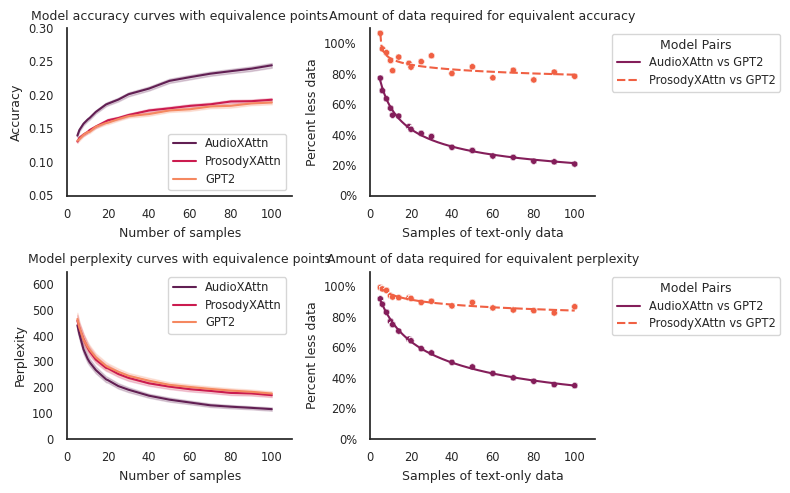

In [ ]:
import seaborn as sns
# sns.reset_orig()
# Turn off the grid using "white" style
sns.set_theme(font_scale=0.75) 
sns.set_style("white")

df_visual = df_comparisons[df_comparisons['true_subset'] >= 5]

ax = whisper.plot_all_comparisons(df_visual, 'GPT2', palette='rocket', remove_outliers=False)

## Visualize cross attention patterns

### Model loading

In [ ]:
import torch

import hydra
from hydra import initialize, compose
from lightning import LightningDataModule, LightningModule

import pyrootutils

from src import utils
from src.data.components.audio_text_dataset import AudioTextDataset
from src.data.components.collators import audio_text_collator

def load_model(config_path, overrides, ckpt_path=None):
    
    with initialize(version_base="1.3", config_path=config_path):
      cfg = compose(config_name="train.yaml", overrides=overrides)

    model: LightningModule = hydra.utils.instantiate(cfg.model)

    # Load the model from a checkpoint
    if ckpt_path:
      checkpoint = torch.load(ckpt_path, map_location=torch.device('cpu'))
      model.load_state_dict(checkpoint['state_dict'])
      model.eval()

    return cfg, model

In [ ]:
dataset = 'gigaspeech-m'
model_name = 'careful-whisper_causal-xattn-subset-0.30'
MODELS_DIR = os.path.join(BASE_DIR, 'code/modeling/joint-clm-prosody/')
CKPTS_DIR = os.path.join(MODELS_DIR, f'logs/train/careful-whisper/{dataset}/')

EXPERIMENT = ["experiment=careful_whisper.yaml"]

# Whisper w/ CLM integration
overrides =  [
    # f"model.config.num_layers=6",
    f"model.config.cross_attention=True",
    f"model.config.use_causal_cross_attention=True",

    # Add in dropout and position embedding
    f"model.config.context_embed_dropout=0.1",
    f"model.config.context_pos_embed=True",

    # for prosody
    # f"model.config.context_type=prominence",
    # f"model.config.context_dim=1",
]

overrides = EXPERIMENT + overrides

pyrootutils.setup_root(MODELS_DIR, indicator=".project-root", pythonpath=True)

# # Get relative path --> path for initialize needs to be relative
config_path = os.path.join(os.path.relpath(MODELS_DIR, os.getcwd()), 'configs')
# cfg, model = load_model(config_path, ckpt_path, overrides)

### Visualization functions

In [ ]:
from typing import List, Optional, Union


import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy

class AttentionWeightTracker(nn.Module):
    """
    Wrapper to track cross-attention weights from MultiheadAttention
    """
    def __init__(self, attention_module):
        super().__init__()
        self.attn = attention_module
        self.last_qk = None
    
    def forward(self, query, key, value, key_padding_mask=None, attn_mask=None, is_causal=False):
        # Perform standard attention
        wv, qk = self.attn(
            query, key, value, 
            key_padding_mask=key_padding_mask,
            attn_mask=attn_mask,
            is_causal=is_causal
        )
        
        # Store attention weights
        self.last_qk = qk.detach()
        
        return wv, qk

# def visualize_cross_attention(attention_weights): #, input_tokens=None, target_tokens=None):
#     """
#     Visualize cross-attention patterns between input and target sequences.
    
#     Args:
#     - attention_weights: Tensor of cross-attention weights (shape: target_len x input_len)
#     - input_tokens: List of input token representations
#     - target_tokens: List of target token representations
#     """
#     plt.figure(figsize=(12, 8))
#     sns.heatmap(
#         attention_weights.squeeze().detach().numpy(), 
#         # xticklabels=input_tokens, 
#         # yticklabels=target_tokens,
#         cmap='viridis'
#     )
#     plt.title('Cross-Attention Patterns')
#     plt.xlabel('Input Sequence')
#     plt.ylabel('Target Sequence')
#     plt.tight_layout()
#     plt.show()

def visualize_cross_attention(
    attention_weights: torch.Tensor, 
    # input_tokens: Optional[List[str]] = None, 
    # target_tokens: Optional[List[str]] = None,
    # titles: Optional[List[str]] = None,
    max_subplots: int = None,
    plots_division: int = 4
):
    """
    Visualize multiple cross-attention weight matrices.
    
    Args:
    - attention_weights: Tensor or list of tensors of attention weights
    - input_tokens: Optional list of input token labels
    - target_tokens: Optional list of target token labels
    - titles: Optional list of subplot titles
    - max_subplots: Maximum number of subplots to display
    """
    # Convert single tensor to list if needed
    # if isinstance(attention_weights, torch.Tensor):
    #     attention_weights = [attention_weights]
    
    # Limit number of subplots
    attention_weights = attention_weights[:max_subplots]
    
    # Determine subplot layout
    n_plots = len(attention_weights)
    rows = (n_plots + 1) // plots_division  # Ceil division
    cols = min(n_plots, plots_division)
    
    # Create figure
    plt.figure(figsize=(6*cols, 5*rows))
    
    # Plot each attention weight matrix
    for i, weights in enumerate(attention_weights, 1):
        plt.subplot(rows, cols, i)
        
        # Transpose to match desired orientation
        weights_np = weights.squeeze().detach().cpu().numpy().T
        
        sns.heatmap(
            weights_np, 
            # xticklabels=target_tokens, 
            # yticklabels=input_tokens,
            cmap='viridis',
            cbar=False,
            square=True
        )
        
        # Set title
        # if titles and i <= len(titles):
        #     plt.title(titles[i-1])
        # else:
        plt.title(f'Attention Matrix {i}')

        plt.xlabel('Target')
        plt.ylabel('Input')
    
    plt.tight_layout()
    plt.show()

def extract_cross_attention(model, batch):
    """
    Extract cross-attention weights from a transformer model.
    
    Returns:
    - Aggregated cross-attention weights across layers
    """
    # Wrap cross-attention layers with weight tracker

    model = deepcopy(model)

    attention_trackers = []
    for block in model.model.blocks:
        original_cross_attn = block.cross_attn.attn
        tracked_cross_attn = AttentionWeightTracker(original_cross_attn)
        block.cross_attn.attn = tracked_cross_attn
        attention_trackers.append(tracked_cross_attn)
    
    # Perform forward pass
    with torch.no_grad():
        model(batch)
    
    # Collect weights
    weights = [tracker.last_qk for tracker in attention_trackers]
    
    # Restore original attention modules
    for i, block in enumerate(model.model.blocks):
        block.cross_attn.attn = attention_trackers[i].attn
    
    # Aggregate weights
    return torch.stack(weights) #.mean(dim=0)

### Grab data for visualization

In [ ]:
for i, batch in enumerate(dataloader):
    if i == 10:

        sys.exit(0)

/dartfs/rc/lab/F/FinnLab/tommy/isc_asynchrony_behavior/code/modeling/joint-clm-prosody/src/data/components/audio_text_dataset.py:646: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feat

SystemExit: 0

/dartfs/rc/lab/F/FinnLab/tommy/conda/envs/prosody/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3587: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


### Visualize XAttn Patterns

#### 10% of data XAttn

/scratch/ipykernel_459143/175680163.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path, map_location=torch.device('cpu'))


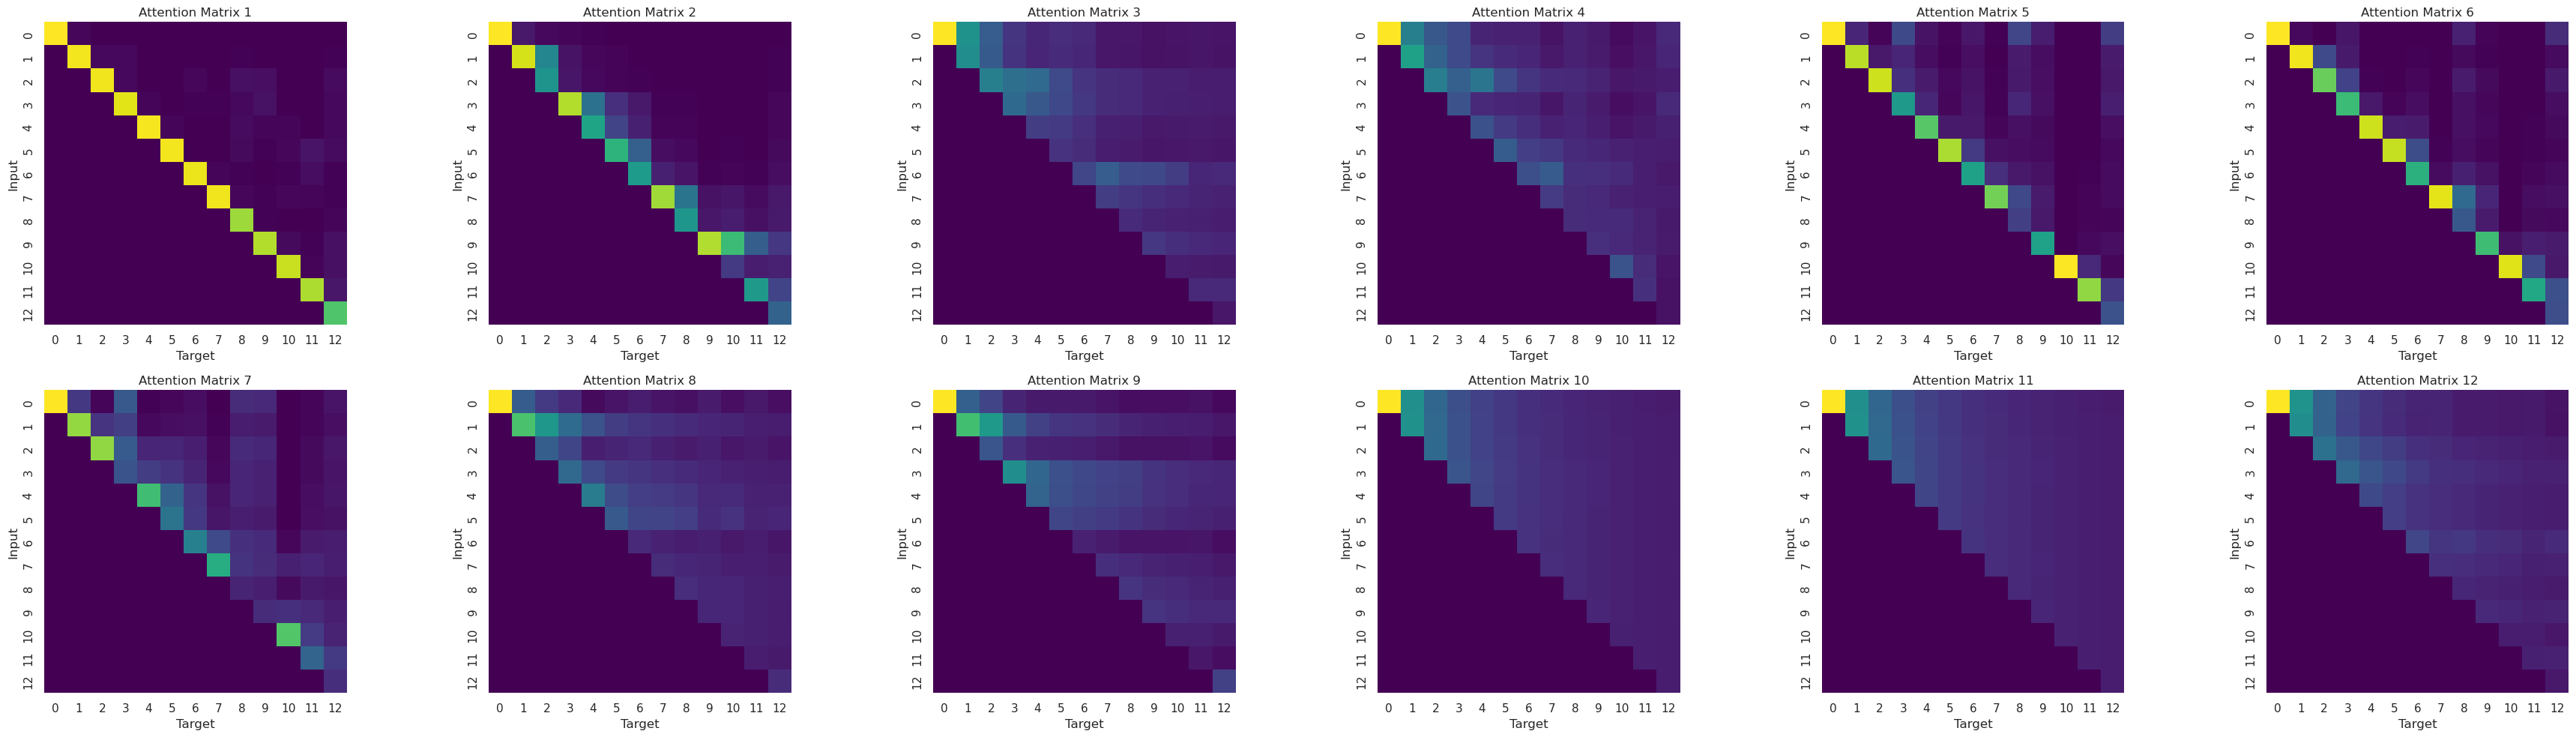

Text(0.5, 0.98, '10% data XAttn')

<Figure size 640x480 with 0 Axes>

In [ ]:
model_name = 'careful-whisper_causal-xattn-subset-0.10'
ckpt_path = glob.glob(os.path.join(CKPTS_DIR, model_name, 'checkpoints', 'epoch*.ckpt'))[-1]
cfg, model = load_model(config_path, ckpt_path, overrides)

attention_weights = extract_cross_attention(model, batch)

visualize_cross_attention(attention_weights.squeeze(), plots_division=6)
plt.suptitle(f'10% data XAttn')

#### 30% of data XAttn

/scratch/ipykernel_459143/175680163.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path, map_location=torch.device('cpu'))


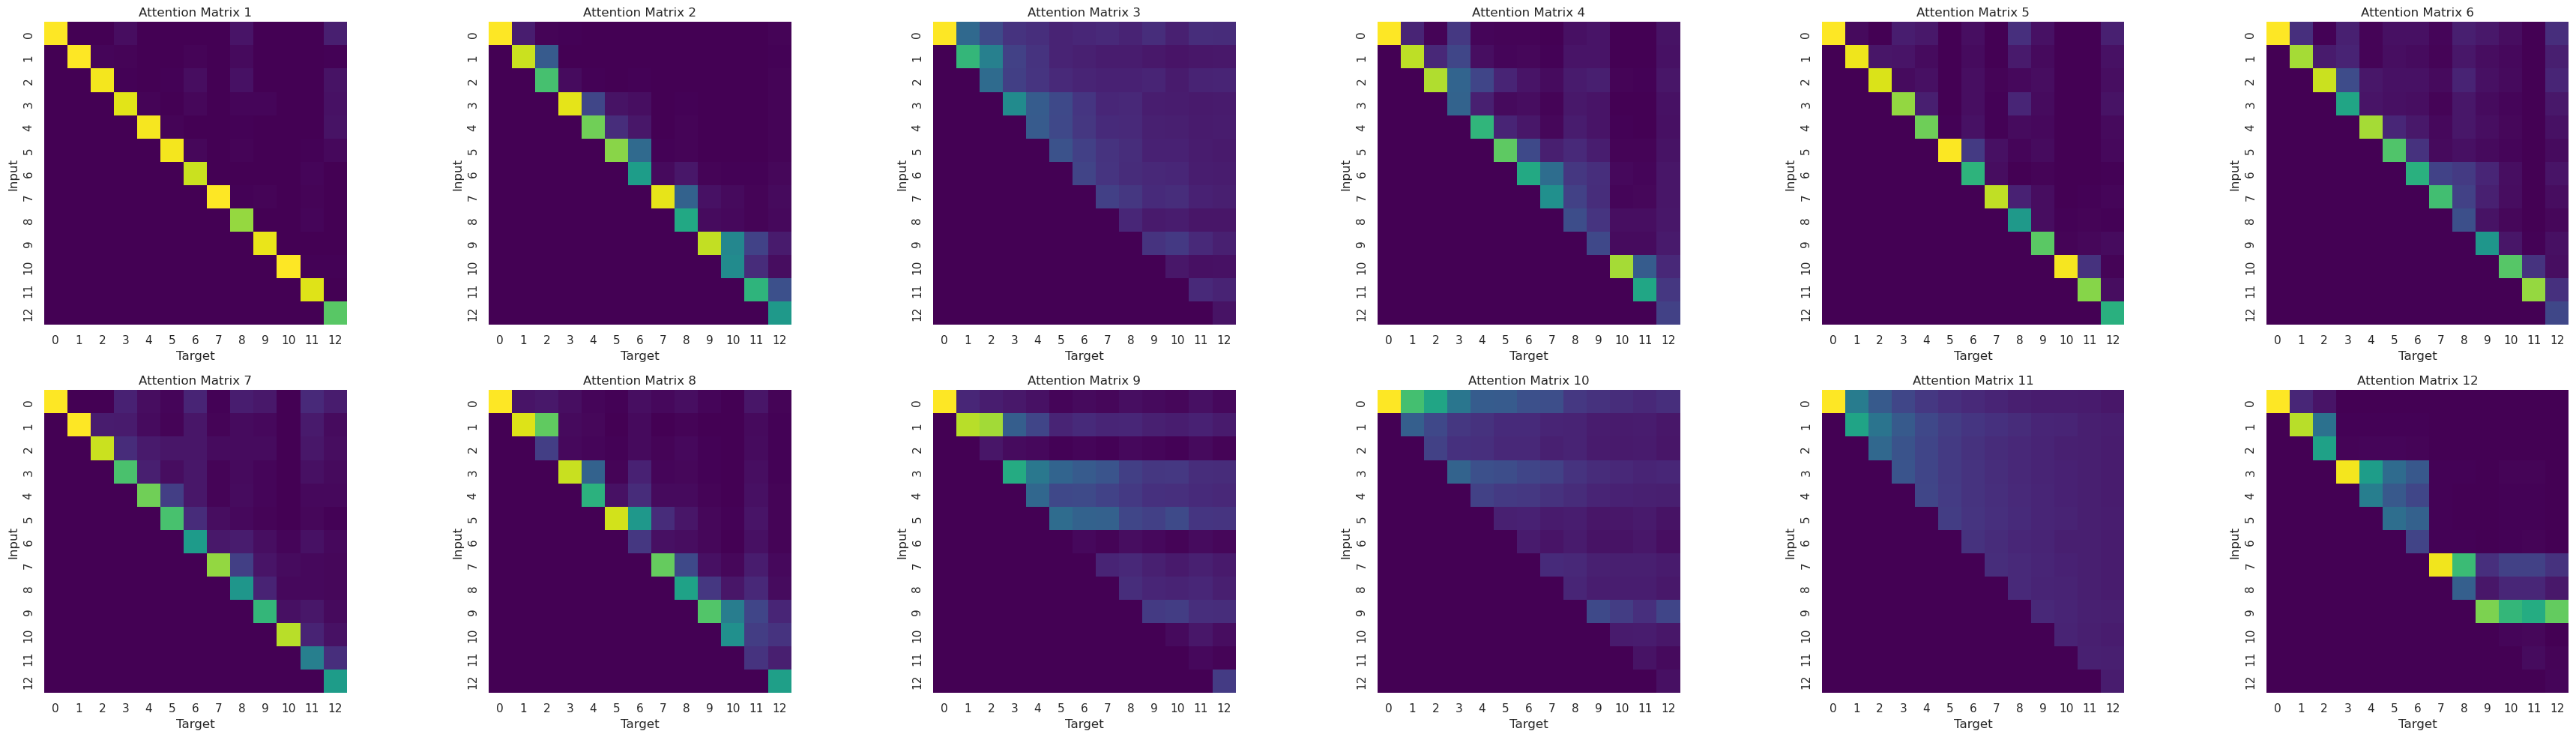

Text(0.5, 0.98, '30% data XAttn')

<Figure size 640x480 with 0 Axes>

In [ ]:
model_name = 'careful-whisper_causal-xattn-subset-0.30'
ckpt_path = glob.glob(os.path.join(CKPTS_DIR, model_name, 'checkpoints', 'epoch*.ckpt'))[-1]
cfg, model = load_model(config_path, ckpt_path, overrides)

attention_weights = extract_cross_attention(model, batch)

visualize_cross_attention(attention_weights.squeeze(), plots_division=6)
plt.suptitle(f'30% data XAttn')

#### 50% data XAttn

/scratch/ipykernel_459143/175680163.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path, map_location=torch.device('cpu'))


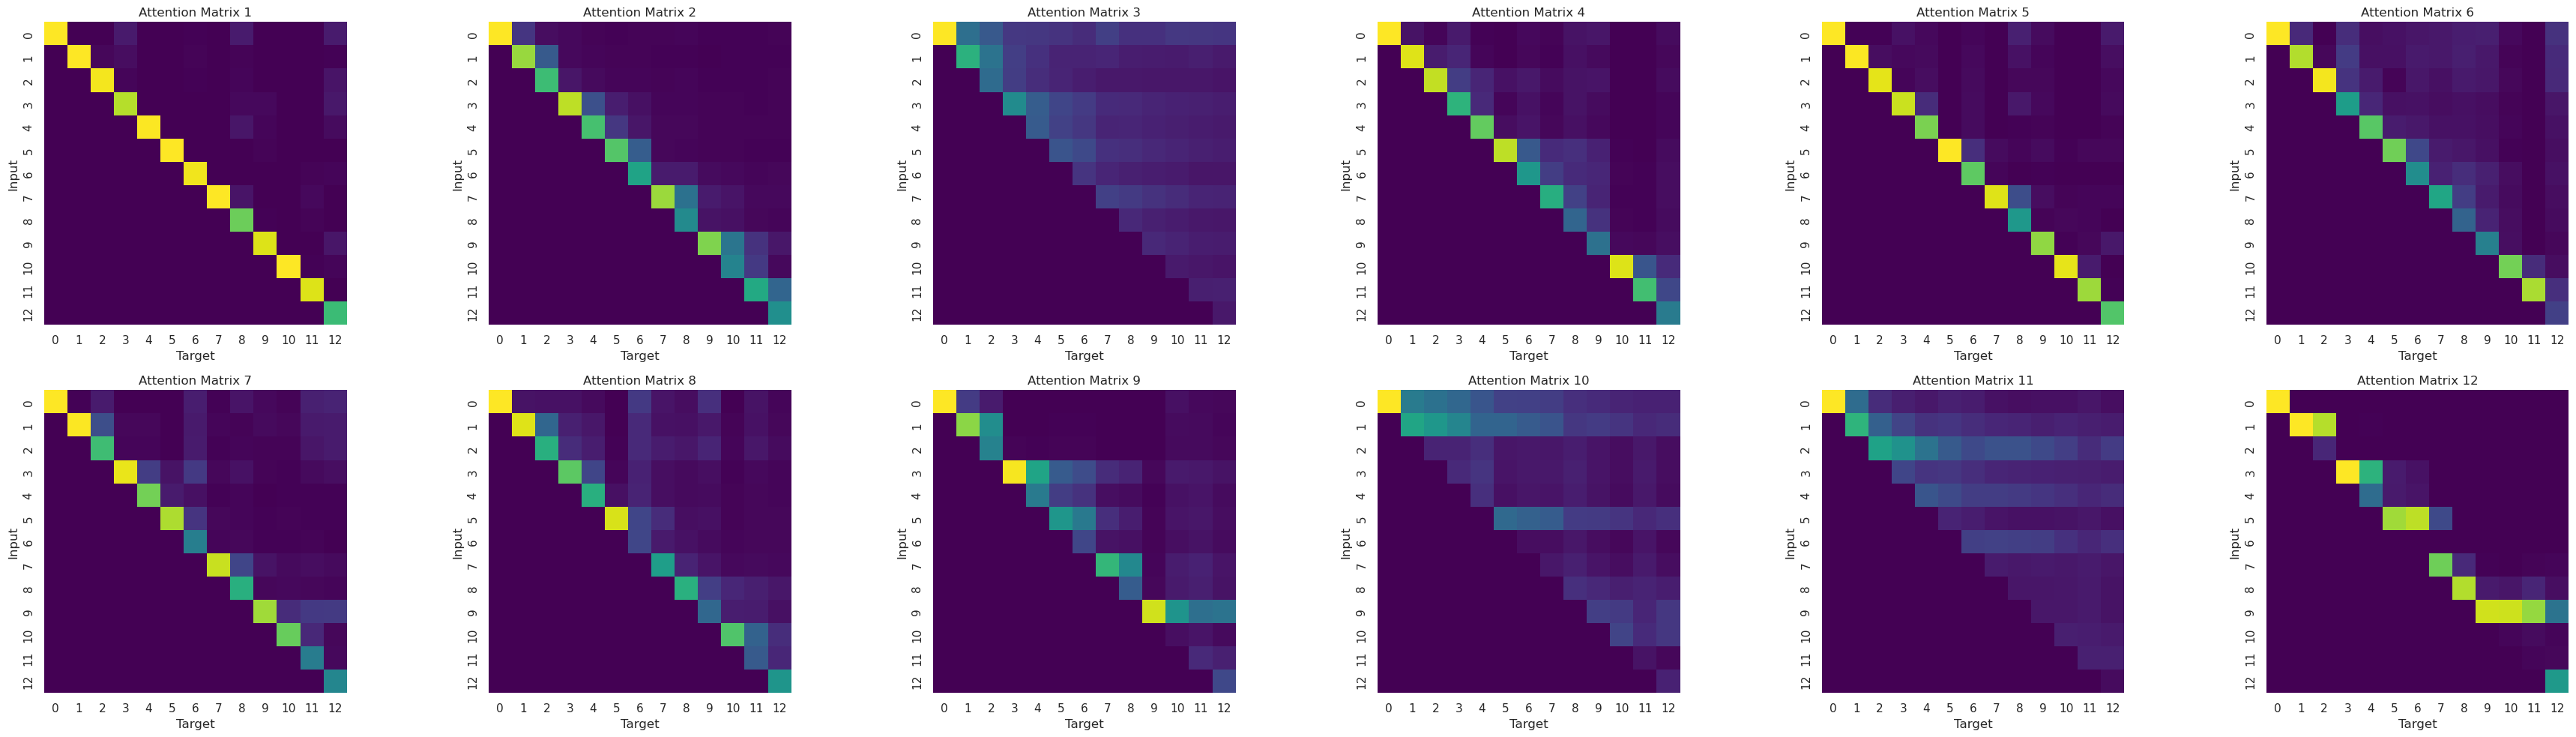

Text(0.5, 0.98, '50% data XAttn')

<Figure size 640x480 with 0 Axes>

In [ ]:
model_name = 'careful-whisper_causal-xattn-subset-0.50'
ckpt_path = glob.glob(os.path.join(CKPTS_DIR, model_name, 'checkpoints', 'epoch*.ckpt'))[-1]
cfg, model = load_model(config_path, ckpt_path, overrides)

attention_weights = extract_cross_attention(model, batch)

visualize_cross_attention(attention_weights.squeeze(), plots_division=6)
plt.suptitle(f'50% data XAttn')

#### 100% data XAttn

/scratch/ipykernel_459143/175680163.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path, map_location=torch.device('cpu'))


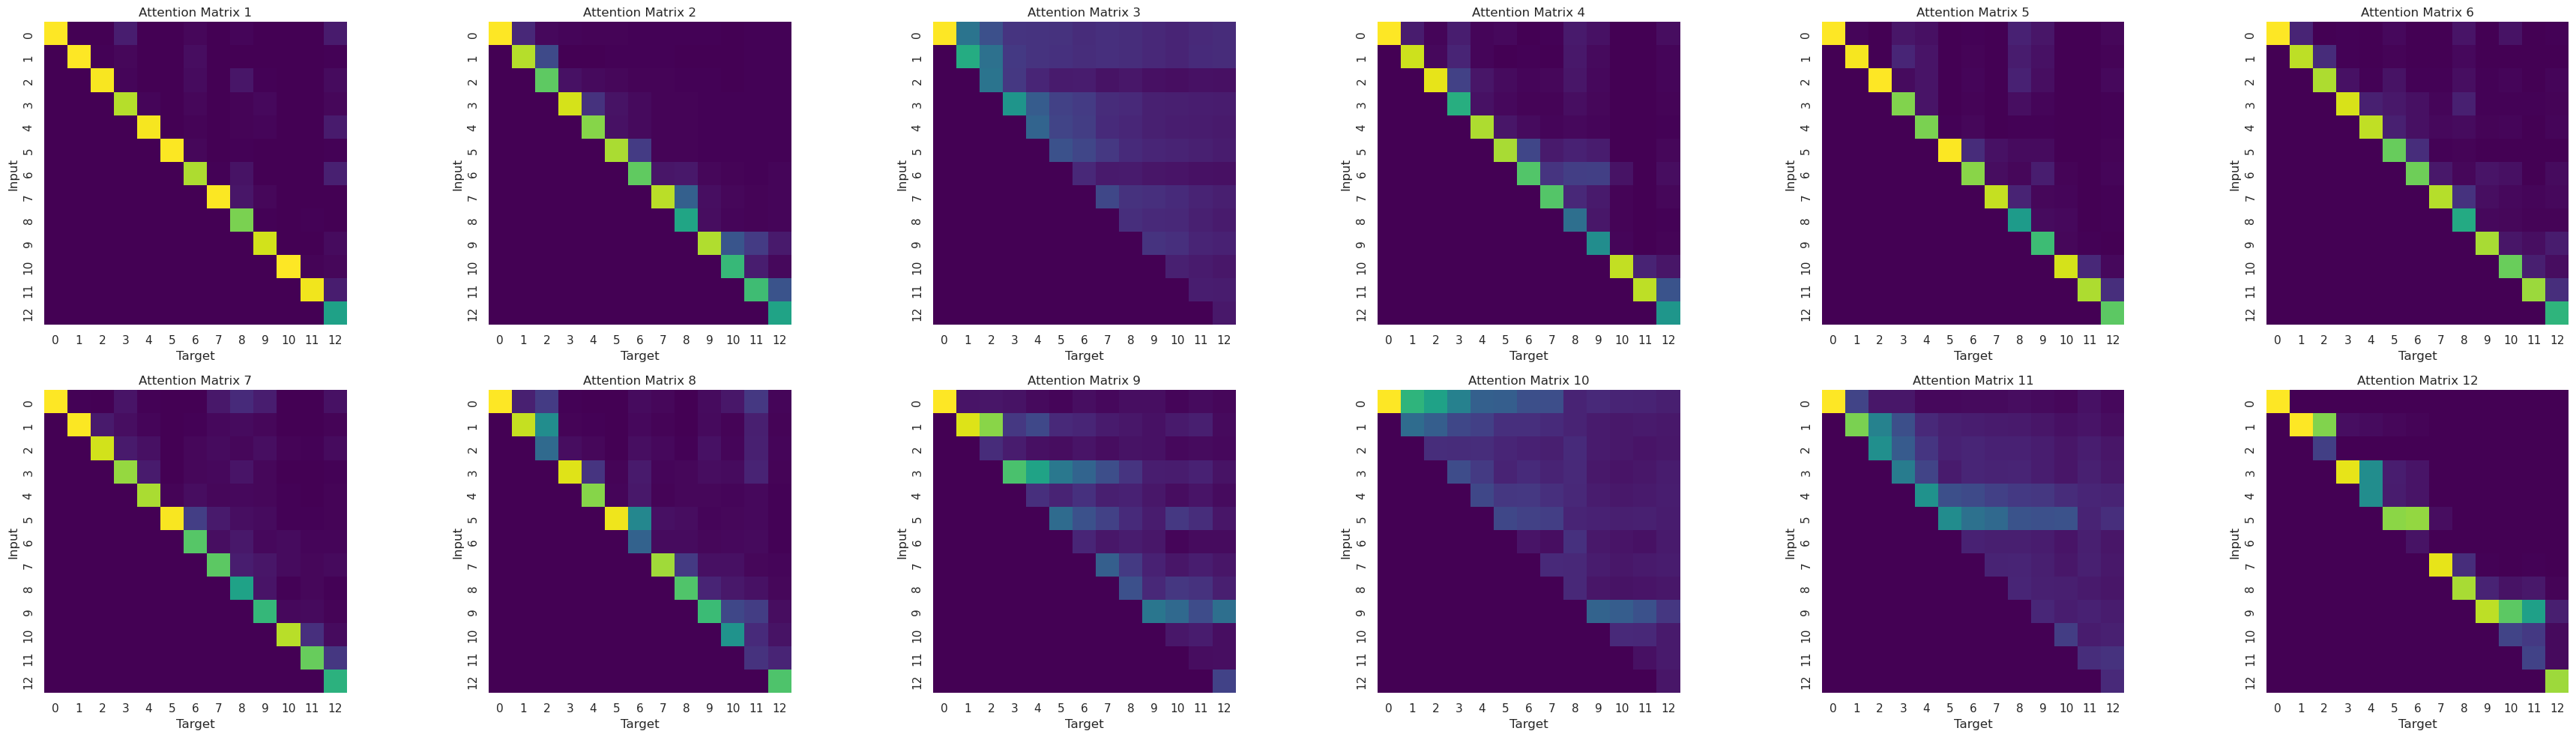

Text(0.5, 0.98, '100% data XAttn')

<Figure size 640x480 with 0 Axes>

In [ ]:
model_name = 'careful-whisper_causal-xattn'
ckpt_path = glob.glob(os.path.join(CKPTS_DIR, model_name, 'checkpoints', 'epoch*.ckpt'))[-1]
cfg, model = load_model(config_path, ckpt_path, overrides)

attention_weights = extract_cross_attention(model, batch)

visualize_cross_attention(attention_weights.squeeze(), plots_division=6)
plt.suptitle(f'100% data XAttn')

## Load joint audio-text dataset

In [ ]:
import torch
from torch.utils.data import DataLoader
from src.data.components.collators import audio_text_collator


# Shuffle labels inplace within a mask
def shuffle_masked_values(labels, mask):
    _labels = labels.clone()

    mask = mask.to(bool)
    masked_values = _labels[mask]
    _labels[mask] = masked_values[torch.randperm(masked_values.numel())]

    return _labels

dataset = AudioTextDataset(
    dataset_dir=os.path.join(DATASETS_DIR, 'nlp-datasets/libritts-r/'),
    cache_dir=os.path.join(SCRATCH_DIR, 'nlp-datasets/libritts-r/'),
    split='test-clean',
)


# dataset = AudioTextDataset(
#     dataset_dir=os.path.join(DATASETS_DIR, 'nlp-datasets/gigaspeech/m'),
#     cache_dir=os.path.join(SCRATCH_DIR, 'nlp-datasets/gigaspeech/m'),
#     split='validation'
# )

# dataset._initialize_models()
dataset.preprocess_data()

train_dataloader = DataLoader(
    dataset=dataset,
    batch_size=32,
    num_workers=0,
    pin_memory=False,
    collate_fn=audio_text_collator,
    shuffle=False,
)

Metadata exists. Processing only new files...
No new files to process


## Load wavelet prosody dataset

In [ ]:
from src.data.wavelet_prominence_datamodule import WaveletDataModule

In [ ]:
data_dir = os.path.join(BASE_DIR, 'modeling/joint-clm-prosody/data/gigaspeech/m/prosody')

'/dartfs/rc/lab/F/FinnLab/tommy/isc_asynchrony_behavior/'

In [ ]:
data_module = WaveletDataModule(
    data_dir = os.path.join(BASE_DIR, 'code/modeling/joint-clm-prosody/data/gigaspeech/m/prosody'),
    dataset_name = 'gigaspeech',
    batch_size = 32,
    model_name = 'gpt2'
)

# data_module.setup('fit')
    # max_length: int = 128,
    # num_workers: int = 0,
    # pin_memory: bool = False,

Using GPT2 tokenizer


/dartfs/rc/lab/F/FinnLab/tommy/conda/envs/prosody/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Dataloader: padding with token id: 50256
Loading data from /dartfs/rc/lab/F/FinnLab/tommy/isc_asynchrony_behavior/code/modeling/joint-clm-prosody/data/gigaspeech/m/prosody


909348it [51:08, 296.38it/s]
5698it [00:19, 285.86it/s]
Preprocessing samples:   4%|▎         | 29257/823538 [00:25<11:28, 1153.17it/s]


KeyboardInterrupt: 

In [ ]:
from src.data.components.collators import audio_text_collator

collate_fn = lambda x: audio_text_collator(x, pad_token=50526)

train_dataloader = DataLoader(
    dataset=dataset,
    batch_size=32,
    num_workers=0,
    pin_memory=False,
    collate_fn=collate_fn,
    shuffle=False,
)

In [ ]:
torch.load(dataset.metadata[i]['audio_tensor_path'])

/scratch/ipykernel_2225583/2341819074.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(dataset.metadata[i]['audio_tensor_path'])


EOFError: Ran out of input

In [ ]:
dataset.metadata[i-1]

{'text': 'and theres a lot of different tools that powerpoint has so that you can help align your content so',
 'audio_tensor_path': '/dartfs-hpc/scratch/f003rjw/gigaspeech/m/wav2vec2-gpt2/train/YOU0000005268_S0000490.pt',
 'text_tokens': [290,
  262,
  411,
  257,
  1256,
  286,
  1180,
  4899,
  326,
  1176,
  4122,
  468,
  523,
  326,
  345,
  460,
  1037,
  10548,
  534,
  2695,
  523],
 'text_attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1]}

In [ ]:
# dataset._initialize_models()

# os.remove(dataset.metadata[i]['audio_tensor_path'])
fn = dataset.metadata[i]['audio_tensor_path'].replace('.pt', '.TextGrid')
basefn = os.path.basename(fn)
fn = os.path.join(dataset.textgrid_dir, basefn)
# fn = .replace(dataset.cache_dir, dataset.dataset_dir)

# audio_path = os.path.join(dataset.audio_dir, basefn.replace(".TextGrid", ".wav"))
x = dataset._process_single_file(basefn)

In [ ]:
batch_size = 32
idx = 9800 * batch_size 

for i in range(idx, idx+batch_size):
    x = dataset.__getitem__(i)
    print (x)

{'text': 'like you can tell somebody you love them', 'text_tokens': tensor([ 588,  345,  460, 1560, 8276,  345, 1842,  606]), 'text_attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1]), 'audio_inputs': tensor([[-0.0080, -0.0265, -0.0029,  ..., -0.0096, -0.0244, -0.0091],
        [ 0.0147, -0.0214, -0.0581,  ..., -0.0055, -0.0202,  0.0128],
        [-0.0011, -0.0242, -0.0306,  ..., -0.0073, -0.0252,  0.0011],
        ...,
        [-0.0080, -0.0269, -0.0570,  ..., -0.0041, -0.0235,  0.0097],
        [ 0.0045, -0.0258, -0.0334,  ..., -0.0156, -0.0235,  0.0036],
        [ 0.0003, -0.0238, -0.0091,  ..., -0.0074, -0.0235, -0.0084]])}
{'text': 'security driver and training group is a closed group of which i am an admin of', 'text_tokens': tensor([ 2324,  4639,   290,  3047,  1448,   318,   257,  4838,  1448,   286,
          543,  1312,   716,   281, 13169,   286]), 'text_attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), 'audio_inputs': tensor([[-0.0045, -0.0275, -0.048

/dartfs/rc/lab/F/FinnLab/tommy/isc_asynchrony_behavior/code/modeling/joint-clm-prosody/src/data/components/audio_text_dataset.py:321: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feat

In [ ]:
for i, batch in enumerate(train_dataloader):
    print (i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

EOFError: Ran out of input

In [ ]:
from transformers.modeling_attn_mask_utils import _prepare_4d_causal_attention_mask_for_sdpa, _prepare_4d_attention_mask_for_sdpa
from transformers import AutoConfig

config = AutoConfig.from_pretrained('gpt2')

cw_config = CarefulWhisperConfig(
    n_vocab=config.vocab_size, 
    max_length=128, 
    embed_dim=1024, 
    num_heads=16, 
    num_layers=12, 
    cross_attention=True,
    use_causal_cross_attention=True,
    pad_token_id=config.vocab_size - 1
)

careful_whisper = CarefulWhisper(cw_config)

In [ ]:
from src.data.components.collators import audio_text_collator

batch = [dataset.__getitem__(i) for i in range(5)]
batch = audio_text_collator(batch, pad_token=cw_config.pad_token_id)

In [ ]:
batch['text_attention_mask'].dtype

torch.float32

In [ ]:
outs = careful_whisper.forward(
    x=batch['text_tokens'],
    xa=batch['audio_inputs'],
    mask=batch['text_attention_mask']
)

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
         -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
         -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., -inf, -inf, -inf]])


In [ ]:
from src.utils.torch_utils import clm_loss, get_shifted_labels
from src.models.careful_whisper_module import CarefulWhisperModule

In [ ]:
torch.manual_seed(42)

cw_config = CarefulWhisperConfig(
    n_vocab=config.vocab_size, 
    max_length=128, 
    embed_dim=1024, 
    num_heads=16, 
    num_layers=12, 
    cross_attention=False,
    use_causal_cross_attention=False,
    pad_token_id=config.vocab_size - 1
)

careful_whisper_module = CarefulWhisperModule(cw_config).eval()

In [ ]:
outputs = careful_whisper_module._shared_step(batch, stage='train')
outputs

{'loss': tensor(10.8973, grad_fn=<DivBackward0>),
 'preds': tensor([[25179, 25837, 41599,  3913, 39389, 25816, 38208, 40724, 39389,  3297,
          23151,  4076, 40724,   673, 15852, 16139,  5896, 36574, 32677,  5896,
          10255, 40192, 12677, 15852, 19718, 20060, 32819, 31003, 19114, 20711,
          10107, 15090, 27003],
         [48281, 31953, 11099, 39770, 39770, 39770,  3601,  1213, 39770, 36977,
           3601,  3601, 39770, 39770, 25198, 36977, 39770,  3601,  3601, 36977,
          36977,  3601, 39770, 39770, 39770, 39770,  3601, 23063, 39770, 19718,
          23063, 39770, 39770],
         [ 3708, 31953,  3708, 10718, 29217, 10718, 37524, 10718, 43764, 37996,
          27387, 27387, 27387,    12,    12,    12,    12, 27387,    12, 46869,
             12,    12,    12,    12,    12, 27387, 27387,    12, 27387,    12,
          27387, 15157, 27387],
         [16790, 46948,   495,   495, 41225, 49156, 48206, 48012, 49156, 16790,
          16146, 42230, 42230, 42230,  9568, 

In [ ]:
careful_whisper_module._calculate_metrics(outputs, batch, stage=None)

{'loss': 11.000442504882812, 'perplexity': 59900.640625, 'accuracy': 0.0}

In [ ]:
clm_loss(
    labels=batch['text_tokens'],
    logits=outs,
    mask=batch['text_attention_mask']
)

tensor(11.0872, grad_fn=<DivBackward0>)

### Try bidirectional

In [ ]:
from torch import nn 
import einops

dropout = 0.
embed_dim = 1024
heads = cw_config.num_heads
dim_head = cw_config.embed_dim // cw_config.num_heads

x = batch['text_tokens']
xa = batch['audio_inputs']

position_ids = torch.arange(x.shape[-1], dtype=torch.long, device=x.device)

# Embed tokens (text) + add positional_embeddings
x = (
    careful_whisper_module.model.token_embedding(x)
    + careful_whisper_module.model.positional_embedding(position_ids)
)

# Embedding dropout
x = careful_whisper_module.model.dropout(x).to(xa.dtype)



norm = nn.LayerNorm(embed_dim)# if prenorm else nn.Identity()

scale = dim_head ** -0.5
    # self.context_norm = nn.LayerNorm(context_dim) if prenorm else nn.Identity()

    # self.heads = heads
    # self.scale = dim_head ** -0.5
    # inner_dim = dim_head * heads

dropout = nn.Dropout(dropout)
_qk = nn.Linear(embed_dim, embed_dim, bias=False)
_v = nn.Linear(embed_dim, embed_dim, bias=False)

qk, v = _qk(x), _v(x)


ModuleNotFoundError: No module named 'einops'

In [ ]:
qk, v = _qk(x), _v(x)

In [ ]:
qk

tensor([[[ 1.6375e-02,  2.7591e-02,  7.1357e-03,  ..., -1.2994e-02,
          -1.1031e-02,  1.8726e-02],
         [-1.9620e-02, -9.2558e-03, -2.3474e-02,  ..., -2.1945e-03,
           4.4397e-04,  2.4094e-02],
         [-2.4908e-03, -3.4152e-02, -1.1986e-02,  ...,  2.2161e-03,
           1.8261e-02, -6.9909e-03],
         ...,
         [ 4.7331e-03,  1.8451e-02,  2.1289e-03,  ...,  2.0046e-03,
           3.3791e-03,  3.3776e-03],
         [-1.3525e-02,  2.4305e-02, -9.8312e-03,  ..., -2.9046e-02,
          -1.7520e-02,  2.0700e-02],
         [-1.1261e-04, -9.5387e-03, -2.7790e-02,  ..., -5.6466e-03,
           5.5343e-05, -1.4955e-03]],

        [[ 1.7249e-03,  1.8887e-02,  9.2706e-03,  ..., -2.2570e-03,
          -7.6634e-03,  1.4991e-02],
         [-2.6328e-02, -2.2675e-02, -3.3232e-02,  ..., -7.8274e-03,
           4.7442e-03,  1.2417e-02],
         [ 2.2732e-02, -1.1142e-02, -1.8777e-02,  ...,  1.5367e-02,
           9.1312e-03,  5.6401e-03],
         ...,
         [ 4.3591e-03,  1

### Run for padded

In [ ]:
import torch
from transformers import AutoTokenizer, GPT2LMHeadModel

tokenizer = AutoTokenizer.from_pretrained("openai-community/gpt2")
tokenizer.pad_token = tokenizer.eos_token
model = GPT2LMHeadModel.from_pretrained("openai-community/gpt2")

inputs = tokenizer(["Hello, my dog is cute", "my cat went to"], padding=True, return_tensors="pt")
outputs = model(**inputs, labels=inputs["input_ids"])
loss = outputs.loss
logits = outputs.logits

/dartfs/rc/lab/F/FinnLab/tommy/conda/envs/prosody/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
from transformers import AutoFeatureExtractor, AutoModel, WhisperModel, AutoConfig
from transformers.models.gpt2.modeling_gpt2 import GPT2Block

whisper_model = WhisperModel.from_pretrained("openai/whisper-base")
config = AutoConfig.from_pretrained('gpt2')
# config.add_cross_attention = True

model = AutoModel.from_config(config)